SVI

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optim
from jax import random

from pydd.binary import *
from pydd.analysis import *
from pydd.noise import *

In [53]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


def log_prob_guide(theta):
    return jnp.log(jnp.ones_like(theta).sum())


def loss(theta):
    gamma_s = dd_s.gamma_s * (1 + 1e-4 * theta[0])
    M_chirp_MSUN = dd_s.M_chirp / MSUN * (1 + 1e-6 * theta[1])
    tT_c = 20 * theta[2]
    dd_h = DynamicDress(
        gamma_s,
        dd_s.c_f,
        M_chirp_MSUN * MSUN,
        dd_s.q,
        dd_s.Phi_c,
        tT_c,
        dd_s.dL_iota,
        dd_s.f_c
    )
    ll = loglikelihood(dd_h, dd_s, f_l, dd_s.f_c, 3000, 3000)
    elbo = ll - log_prob_guide(theta)
    return -elbo


loss_and_grad = jax.value_and_grad(loss)

In [33]:
(15.84577 - dd_s.M_chirp/MSUN) / (dd_s.M_chirp/MSUN) / 1e-6

DeviceArray(0.37620752, dtype=float64)

In [55]:
loss_and_grad(jnp.array([0., 0., 0.]))

(DeviceArray(-41.16400801, dtype=float64),
 DeviceArray([-4.81515163e-07,  1.09173038e-06,  3.19469469e-07], dtype=float64))

In [54]:
loss_and_grad(theta_init)

(DeviceArray(-40.99908333, dtype=float64),
 DeviceArray([-4.53048519,  8.24358764, -3.71211472], dtype=float64))

In [1]:
theta_init = jnp.array([0.5, 0.4, -0.5]) * 3# * 0.1
losses = []
thetas = []
grads = []

num_steps = 200
lr = 5e-3  # lambda i: 5e-3 if i < 50 else 2e-1
opt_init, opt_update, get_params = optim.adam(lr, b1=0.5)
opt_state = opt_init(theta_init)

with trange(num_steps) as pbar:
    for i in pbar:
        theta_new = get_params(opt_state)
        value, grad = loss_and_grad(theta_new)
#         grad = grad * jnp.array([1e-16, 1e-19, 1e4])
        opt_state = opt_update(i, grad, opt_state)
        thetas.append(theta_new)
        losses.append(value)
        grads.append(grad)
        pbar.set_description(f"{losses[-1]}")

losses = jnp.stack(losses)
thetas = jnp.stack(thetas)
grads = jnp.stack(grads)

NameError: name 'jnp' is not defined

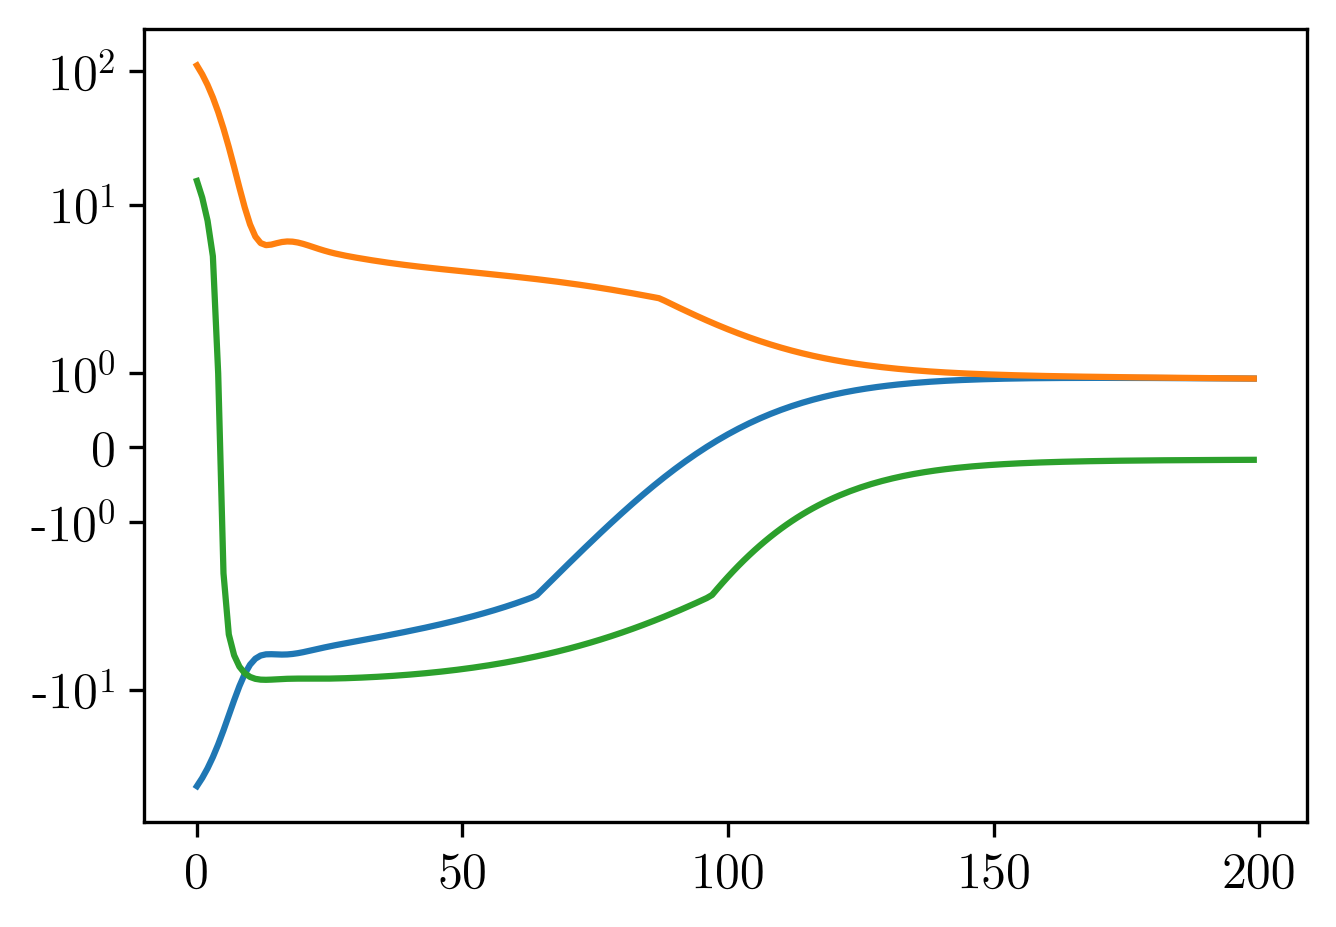

In [96]:
plt.plot(grads)
plt.yscale("symlog")

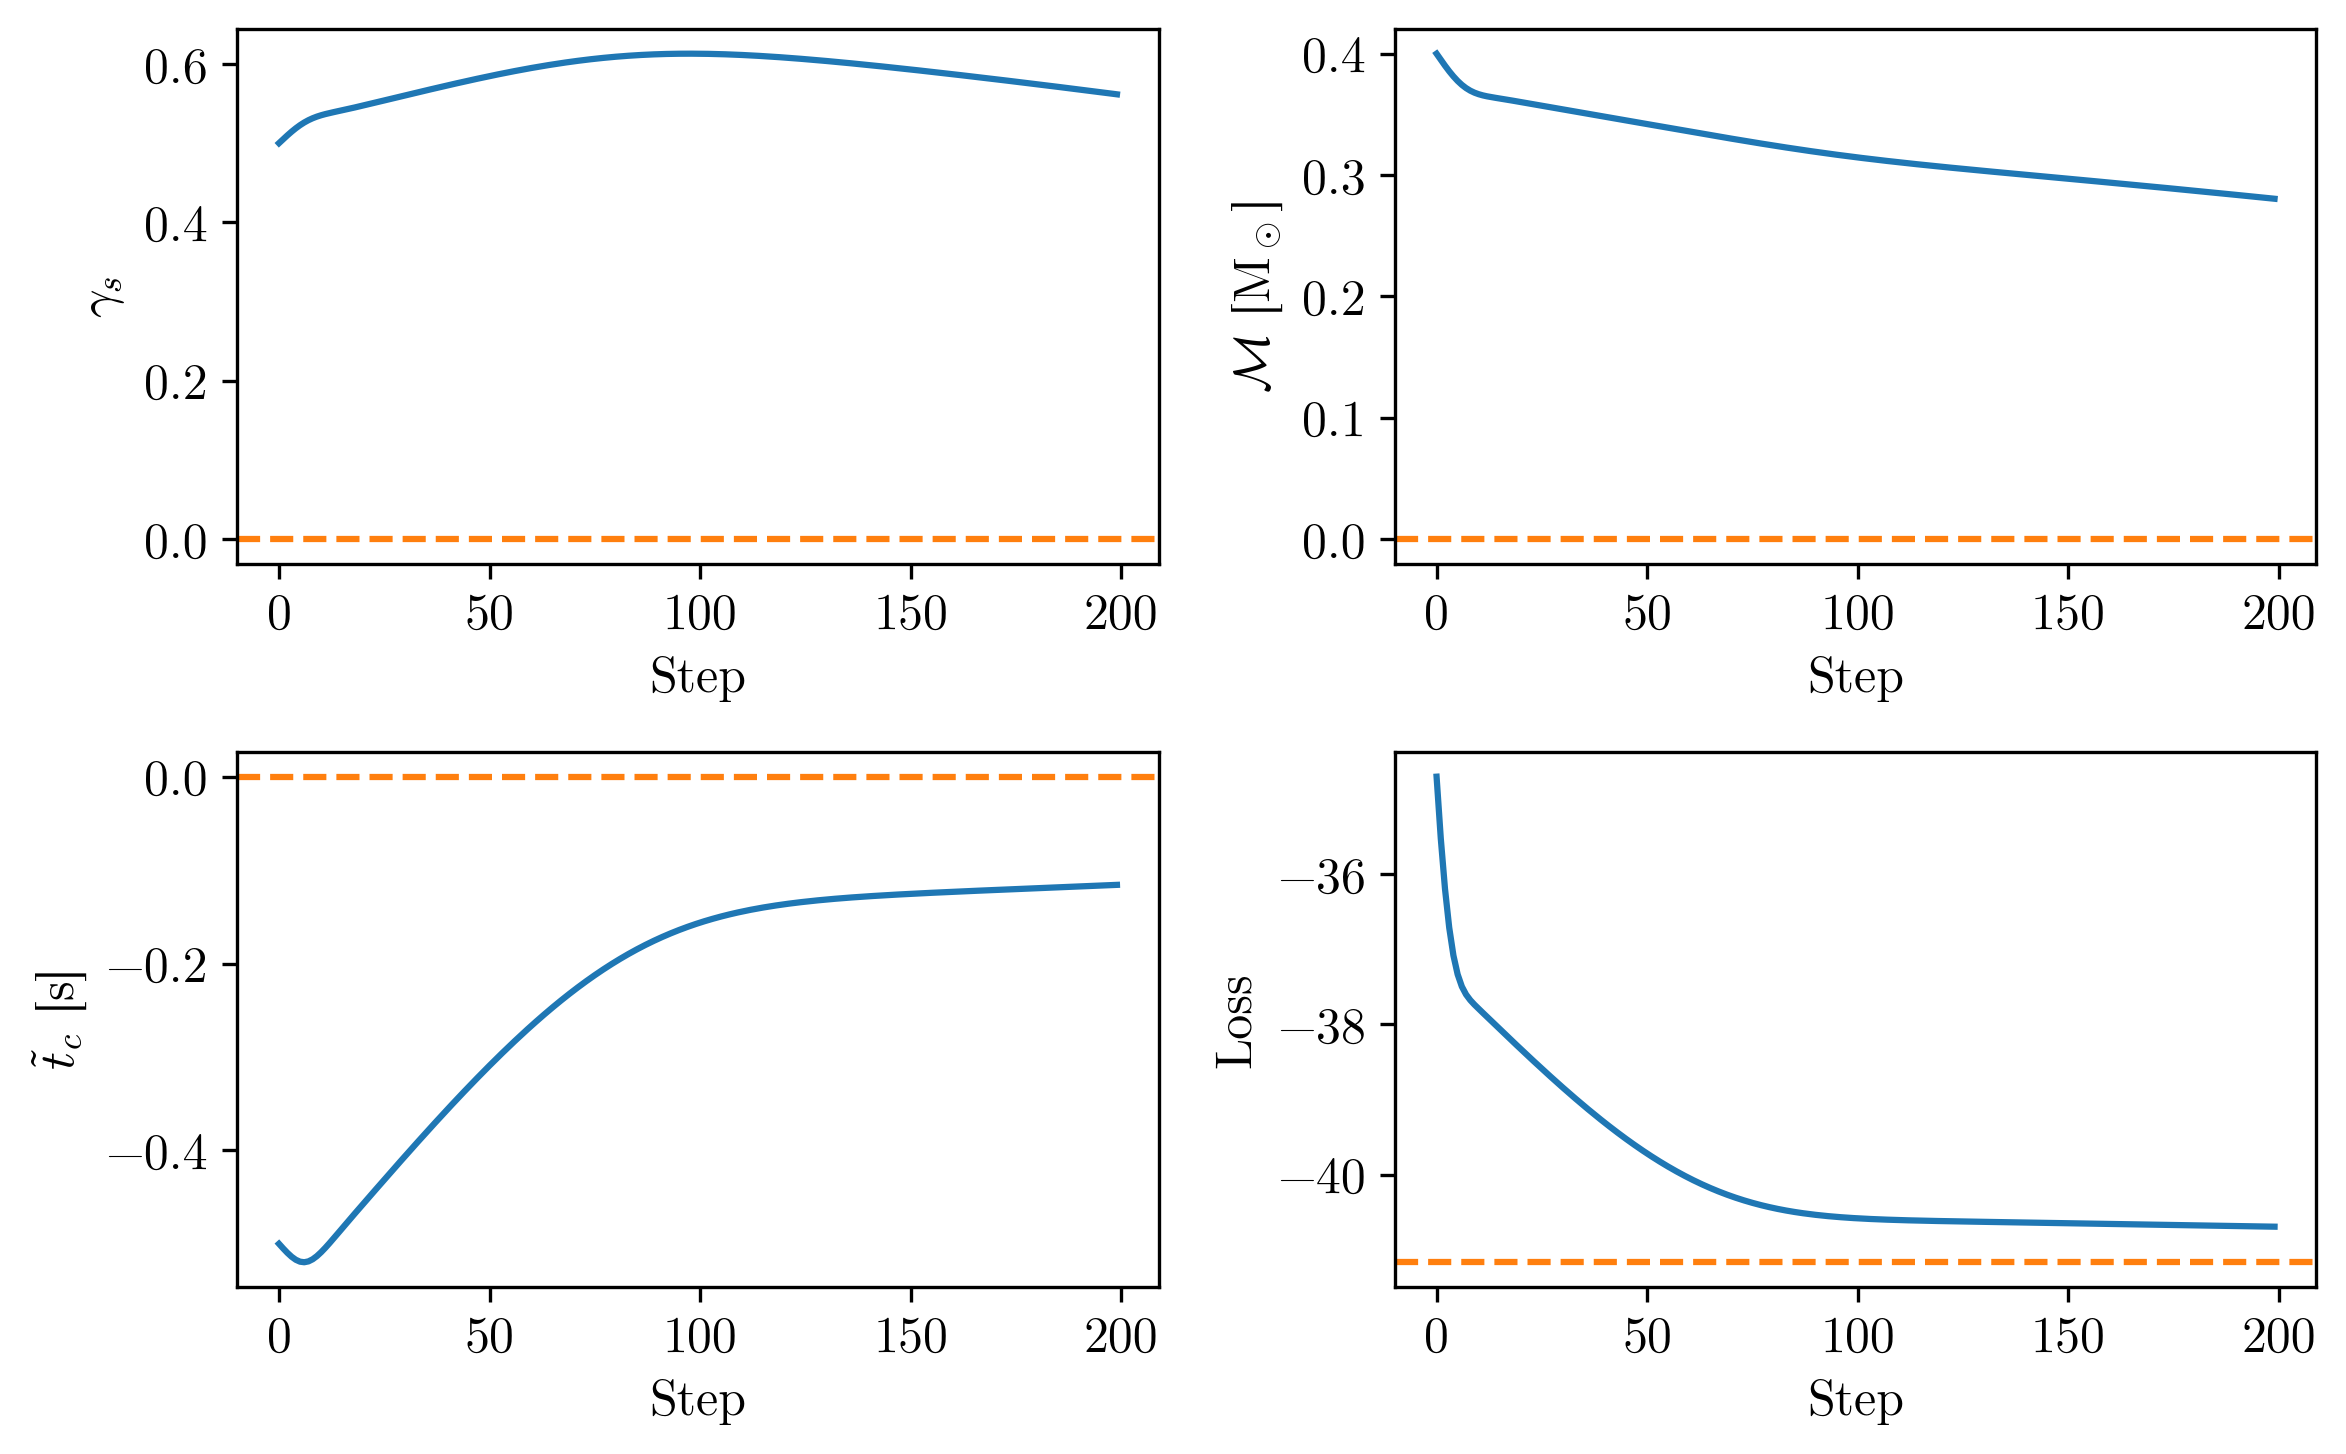

In [97]:
plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
plt.plot(thetas[:, 0])
plt.axhline(0., color="C1", linestyle="--")
plt.xlabel("Step")
plt.ylabel(r"$\gamma_s$")

plt.subplot(2, 2, 2)
plt.plot(thetas[:, 1])
plt.axhline(0., color="C1", linestyle="--")
plt.xlabel("Step")
plt.ylabel(r"$\mathcal{M}$ [M$_\odot$]")

plt.subplot(2, 2, 3)
plt.plot(thetas[:, 2])
plt.axhline(0., color="C1", linestyle="--")
plt.xlabel("Step")
plt.ylabel(r"$\tilde{t}_c$ [s]")

plt.subplot(2, 2, 4)
plt.plot(losses)
plt.axhline(
    loss_and_grad(jnp.array([0., 0., 0.]))[0],
    color="C1", linestyle="--"
)
plt.xlabel("Step")
plt.ylabel("Loss")

# plt.subplot(2, 2, 4)
# plt.plot(grads)

plt.tight_layout()

Text(0, 0.5, '$\\tilde{t}_c$ [s]')

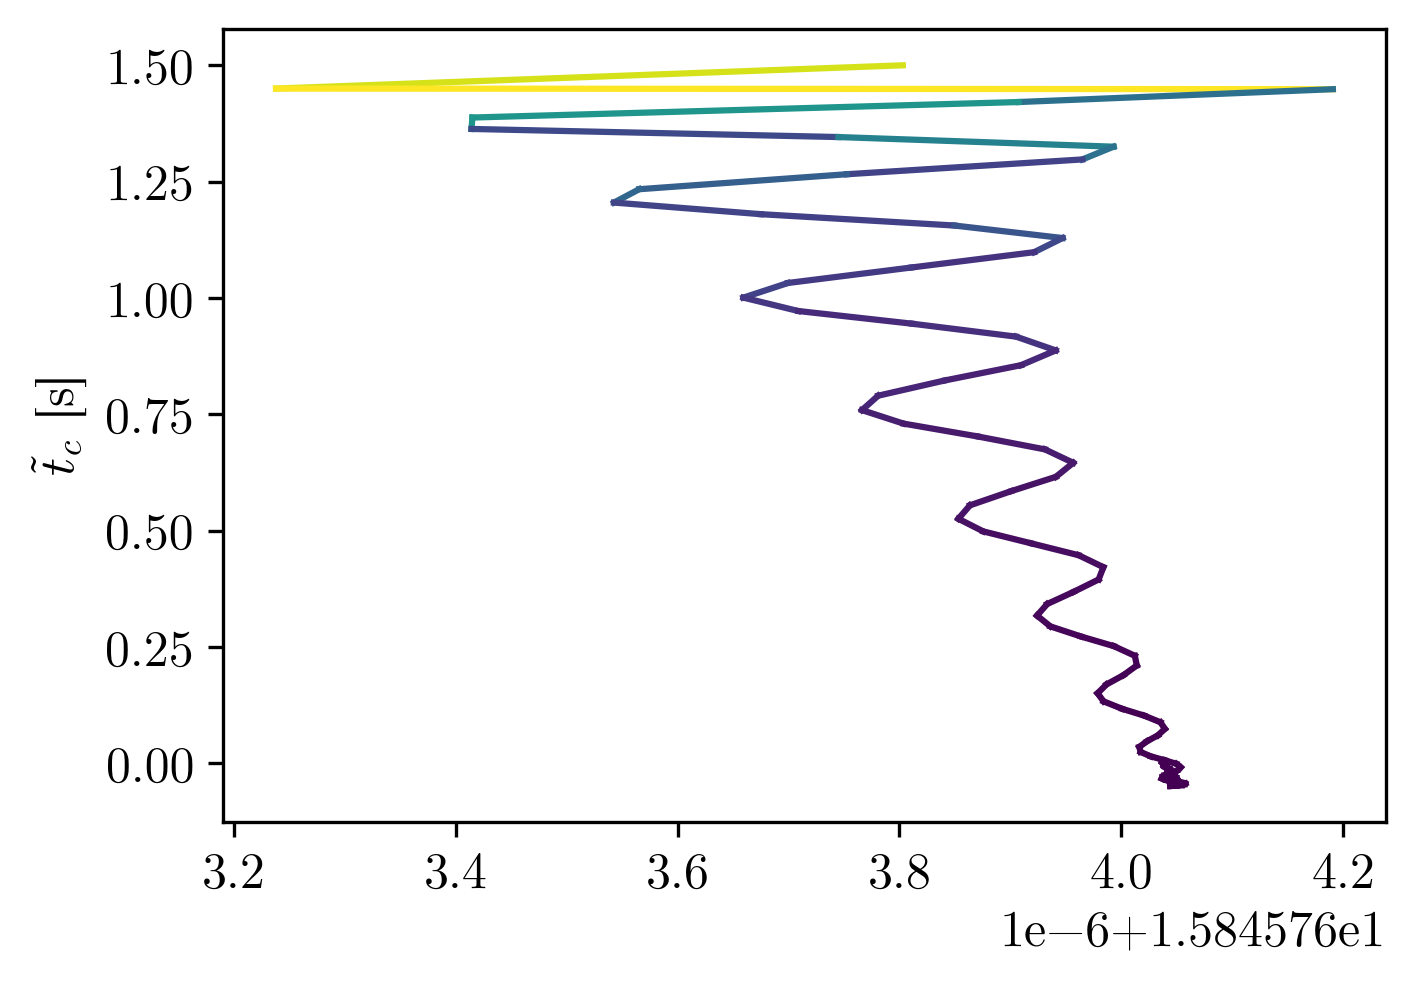

In [151]:
for start, stop, loss in zip(thetas[:-1], thetas[1:], losses[1:]):
    x, y = zip(start, stop)
    z = (loss - losses.min()) / (losses.max() - losses.min())
    plt.plot(x, y, color=plt.cm.viridis(z))

plt.ylabel(r"$\mathcal{M}$ [M$_\odot$]")
plt.ylabel(r"$\tilde{t}_c$ [s]")

In [139]:
def sample_guide(guide_loc):
    return guide_loc

truths = (dd_s.gamma_s, dd_s.M_chirp / MSUN, dd_s.tT_c)
losses = []
guide_loc_0 = jnp.array([2.3335, 15.845767, 10])
guide_locs = [guide_loc_0]
lr = 5e-15

def step():
    theta = sample_guide(guide_locs[-1])
    loss, grad_loss = loss_and_grad(theta)
    guide_locs.append(guide_locs[-1] - lr * grad_loss)
    losses.append(loss.item())

In [140]:
pbar = trange(500)
for i in pbar:
    step()
    pbar.set_description(f"{losses[-1]}")

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
loss_and_grad(jnp.stack(truths))